### Training a classifier to identify transcription factor (TF) motifs

In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
from nn.nn import NeuralNetwork
from nn import io, preprocess 
import numpy as np
import pandas as pd 
import random
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

First, we'll read in the positive and negative sequences. We'll trim the sequences so that they're all the same length. Since the positive class is much smaller than the negative class, we'll randomly sample sequences with replacement from the positive class so that the same number of sequences are in the positive and negative class. I chose this unbiased method for simplicity, although it's possible that we may have wanted to overrepresent certain sequences. By oversampling the positive sequences, we can preserve all information available from the negative sequences. 

In [114]:
#read in sequence files and combine 
pos_seqs=io.read_text_file('./data/rap1-lieb-positives.txt')
neg_seqs=io.read_fasta_file('./data/yeast-upstream-1k-negative.fa')
all_seqs=pos_seqs+neg_seqs

#get min length
min_seq_len=min(len(min(pos_seqs)), len(min(neg_seqs)))

#trim sequences so that they're all the same length 
trimmed_all_seqs=[]
for seq in all_seqs:
    if len(seq)>min_seq_len:
        start=random.randint(0, len(seq)-min_seq_len)
        trimmed_all_seqs.append(seq[start:start+min_seq_len])
    else:
        trimmed_all_seqs.append(seq)
    
#set labels
labels=(['positive'] * len(pos_seqs)) + (['negative'] * len(neg_seqs))        

In [76]:
#resample seqs so same number per label
tf_sampled_seqs, tf_sampled_labels=preprocess.sample_seqs(trimmed_all_seqs, labels)

#check that len of seq and labels match
print(len(tf_sampled_seqs))
print(len(tf_sampled_labels))

6326
6326


We'll then one hot encode the sequences, turn the labels into binary values, and split the data into train and test sets. 

In [77]:
#then, one hot encode the sequesnces
one_hot_encode_tf=preprocess.one_hot_encode_seqs(tf_sampled_seqs)

#turn labels into binary values
tf_labels_binary = [0 if val=='negative' else 1 for val in tf_sampled_labels]

#split train and test 
X_train, X_val, y_train, y_val=train_test_split(one_hot_encode_tf, np.expand_dims(tf_labels_binary, 1), 
                                                  train_size=0.8, random_state=3)
X_train.shape

Next, we'll select hyperparameters. I chose BCE for the loss function since our goal is binary classification. Similarly, while I selected relu previously to avoid the problem of diminishing gradients, I thought sigmoid would be more appropriate here (like in logistic regression). I tested this as one of the hyperparameters just in case. I also tested the learning rate and batch size, and selected the hyperparamter combination that provided the lowest validation loss.   

The input dimensions were selected somewhat arbitrarily, by halving the dimensions of the one hot encoded sequences twice. The final output dimension is 1 since we are making a single prediction of 0 or 1. If I had more time, I would  tune the input dimensions. I would also tune the number of epochs so we aren't training for too long. 

In [115]:
#tune some hyperparameters 


#test lr, batch_size
lr_test=[0.01, 0.001]
batch_size_test=[50, 100, 200]
activation=['relu', 'sigmoid']
hyperparameters=[(x, y, z) for x in lr_test for y in batch_size_test for z in activation]

val_loss_list=[]

print('tuning the following hyperparameters...')
for hp in hyperparameters:
    print('lr, batch_size, activation:', hp)
        
    run_NN = NeuralNetwork(nn_arch = [{'input_dim': 68, 'output_dim': 34, 'activation': hp[2]},
                                      {'input_dim': 34, 'output_dim': 17, 'activation': hp[2]},
                                      {'input_dim': 17, 'output_dim': 1, 'activation': hp[2]}],
                                    lr = hp[0], seed = 3, batch_size = hp[1], epochs = 500, 
                                    loss_function='mse', verbose=False)
    
    per_epoch_loss_train, per_epoch_loss_val=run_NN.fit(X_train, y_train, X_val, y_val)
    
    
    #store average of the last 10 epochs of validation loss 
    val_loss_list.append(np.mean(per_epoch_loss_val[-10:]))

tuning for the following hyperparameters...
lr, batch_size, activation: (0.01, 50, 'relu')
lr, batch_size, activation: (0.01, 50, 'sigmoid')
lr, batch_size, activation: (0.01, 100, 'relu')
lr, batch_size, activation: (0.01, 100, 'sigmoid')
lr, batch_size, activation: (0.01, 200, 'relu')
lr, batch_size, activation: (0.01, 200, 'sigmoid')
lr, batch_size, activation: (0.001, 50, 'relu')
lr, batch_size, activation: (0.001, 50, 'sigmoid')
lr, batch_size, activation: (0.001, 100, 'relu')
lr, batch_size, activation: (0.001, 100, 'sigmoid')
lr, batch_size, activation: (0.001, 200, 'relu')
lr, batch_size, activation: (0.001, 200, 'sigmoid')


In [119]:
#select hyperparameters with minimum validation loss 
hp_idx=np.argmin(val_loss_list)
print('best hyperparameters lr, batch_size:', hyperparameters[hp_idx])

best hyperparameters lr, batch_size: (0.01, 50, 'sigmoid')


We've selected the final hyperparameters. If I had more time, I'd do some cross validation. For today, we will proceed with this final model. 

In [121]:
tf_classifier_NN = NeuralNetwork(nn_arch = [{'input_dim': 68, 'output_dim': 34, 'activation': 'sigmoid'},
                                      {'input_dim': 34, 'output_dim': 17, 'activation': 'sigmoid'},
                                      {'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}],
                            lr = 0.01, seed = 3, batch_size = 50, epochs = 500, loss_function='bce', verbose=False)

In [122]:
per_epoch_loss_train, per_epoch_loss_val=tf_classifier_NN.fit(X_train, y_train, X_val, y_val)

Finally, we'll plot the training and validation loss. 

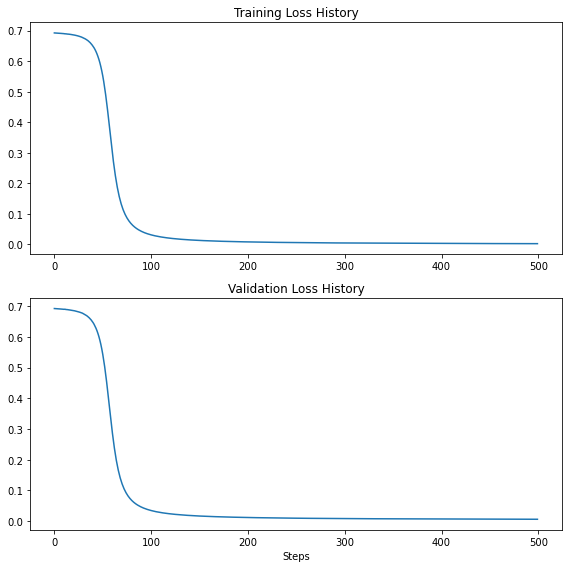

In [104]:
#code from hw7
#plot training and reconstruction loss for final model

fig, axs = plt.subplots(2, figsize=(8, 8))
axs[0].plot(np.arange(len(per_epoch_loss_train)), per_epoch_loss_train)
axs[0].set_title('Training Loss History')
axs[1].plot(np.arange(len(per_epoch_loss_val)), per_epoch_loss_val)
axs[1].set_title('Validation Loss History')
plt.xlabel('Steps')
fig.tight_layout()
plt.show()

The accuracy on the validation set is quite high, at 99.8%. 

In [123]:
tf_pred=tf_classifier_NN.predict(X_val)
tf_pred_binary = np.where(tf_pred > 0.5, 1, 0)

print('Validation set accuracy:', np.sum(tf_pred_binary == y_val)/len(y_val))

Validation set accuracy: 0.9984202211690363
